In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import pickle

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

In [5]:
# We will use Keras' Sequential model from Tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
data = pd.read_csv('../data/raw/SMSSpamCollection', sep='\t', names=['label', 'message'])

In [7]:
data.iloc[28].values

array(['ham',
       "I'm back &amp; we're packing the car now, I'll let you know if there's room"],
      dtype=object)

In [3]:
import html
# Define a function to decode HTML entities
def decode_html_entities(text):
    return html.unescape(text)

In [8]:
data['message'] = data['message'].apply(decode_html_entities)

In [10]:
data.iloc[28].values

array(['ham',
       "I'm back & we're packing the car now, I'll let you know if there's room"],
      dtype=object)

## 🔍 Exploratory Data Analysis (EDA)

In [11]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0, 0.5, 'Number of Data points')

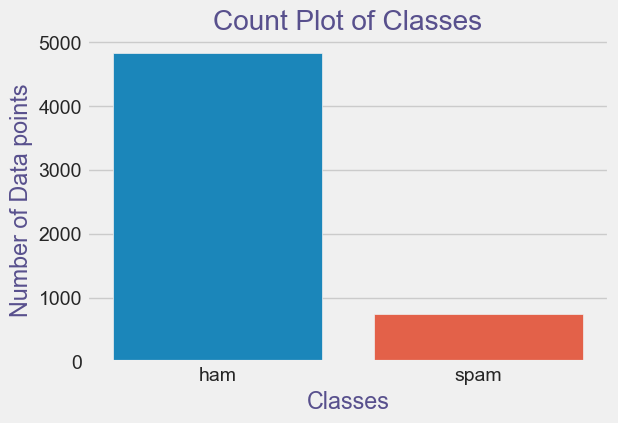

In [12]:
# cols= ["#E1F16B", "#E598D8"]
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(6,4))
fg = sns.countplot(x= data["label"])
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

We have `4825` ham sms and `747` spam sms

In [13]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [14]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's one-hot encode the categorical labels into binary

In [15]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

Create a word cloud, let's seperate the classes into two df

In [16]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

In [18]:
def show_wordcloud(df, title):
  text = ' '.join(df['message'].astype(str).tolist())
  stopwords = set(wordcloud.STOPWORDS)

  fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                                      width=800, height=600).generate(text)
  plt.figure(figsize=(8,5), frameon=True)
  plt.imshow(fig_wordcloud)
  plt.axis('off')
  plt.title(title, fontsize=20 )
  plt.show()




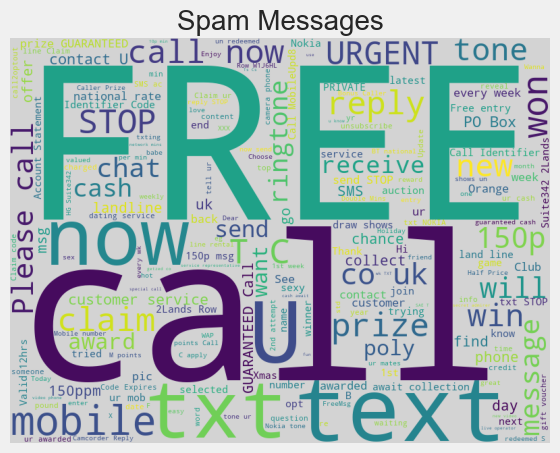

In [19]:
show_wordcloud(data_spam, 'Spam Messages')


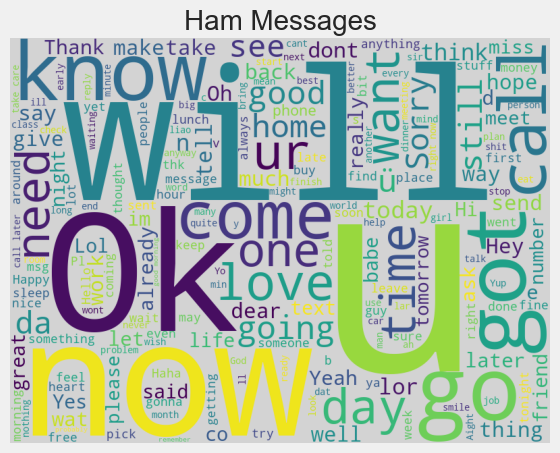

In [20]:
show_wordcloud(data_ham, 'Ham Messages')

## Train-test Split
We split out train and test data first before processing further to prevent data leakage

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# Train-test Split
X = data['message'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Feature Engineering and Pre-processing

In [23]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

vocab_size = len(t.word_index) + 1

print(encoded_train[0:2])

[[85, 2, 169, 482, 458, 119, 33, 5, 3855, 3856, 312, 1265, 30, 2601, 65, 80, 2, 1654, 2, 313, 235], [243, 870, 15, 52, 8, 459, 158, 21, 25, 93, 1655, 75, 1, 59, 1117, 3857, 33, 171, 3, 51, 2602]]


In [46]:
type(t)

keras.preprocessing.text.Tokenizer

In [24]:
# pad documents to a max length of 10 words
max_length = 10
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(padded_train)

[[1265   30 2601 ...    2  313  235]
 [  75    1   59 ...    3   51 2602]
 [  56 3858   47 ...    6  244   97]
 ...
 [1637   31 2483 ... 2484    0    0]
 [ 941 1457 1194 ...    0    0    0]
 [ 114   72   37 ... 1393    0    0]]


## 🛠️ Model Building

In [25]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 30, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 30)            238590    
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 500)               150500    
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

### Model Fitting

In [26]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
          y=y_train,
          epochs=50,
          validation_data=(padded_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/50
140/140 [==============================] - 2s 8ms/step - loss: 0.2027 - accuracy: 0.9248 - val_loss: 0.0558 - val_accuracy: 0.9830
Epoch 2/50
140/140 [==============================] - 1s 6ms/step - loss: 0.0468 - accuracy: 0.9868 - val_loss: 0.0548 - val_accuracy: 0.9857
Epoch 3/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0192 - accuracy: 0.9953 - val_loss: 0.0581 - val_accuracy: 0.9848
Epoch 4/50
140/140 [==============================] - 1s 6ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.0804 - val_accuracy: 0.9848
Epoch 5/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0837 - val_accuracy: 0.9857
Epoch 6/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0931 - val_accuracy: 0.9848
Epoch 7/50
140/140 [==============================] - 1s 5ms/step - loss: 7.3114e-05 - accuracy: 1.0000 - val_loss: 0.1045 - val_accuracy: 0.9839
Ep

## 🔎 Model Evaluation

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [28]:
# Make predictions using Test Data
preds = (model.predict(padded_test) > 0.5).astype("int32")

35/35 [==============================] - 0s 2ms/step


Let's look at our classification report

In [29]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.91      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Accuracy : 0.9856502242152466


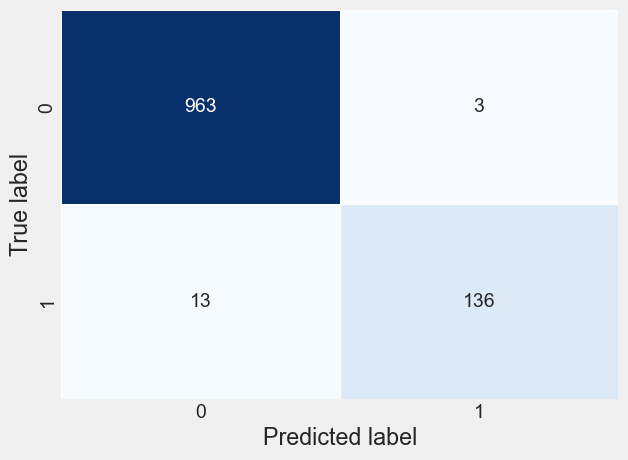

In [30]:
plot_confusion_matrix(y_test, preds)

## 💾 Saving our model 

In [32]:
model.save("../models/keras_model-0.1.0")

INFO:tensorflow:Assets written to: ../models/keras_model-0.1.0\assets


INFO:tensorflow:Assets written to: ../models/keras_model-0.1.0\assets


In [33]:
# save the tokenizer (pre-processing step)
with open('../models/keras_tokenizer-0.1.0.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)


## 🔮 Make Predictions 

Load saved model

In [36]:
%pwd

'E:\\project-spam\\notebooks'

In [37]:
s_model = tf.keras.models.load_model("../models/keras_model-0.1.0")
with open('../models/keras_tokenizer-0.1.0.pkl', 'rb') as input:
    tokenizer = pickle.load(input)


In [38]:
s_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 30)            238590    
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 500)               150500    
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [53]:
def spam_predict(sms, tokenizer_proc=tokenizer, max_length=10):
    '''
    sms: (list) input text in a list
    tokenizer_proc: (tokenizer obj) the type of tokenizer to pre-process the input text/sms
    max_length: (int, def=10) length of padding to ensure the input text/sms have the same shape
    '''
    predict_label = {0:'Ham', 1:'Spam!'}
    
    data = []
    for t in sms:
        sms_proc = tokenizer_proc.texts_to_sequences([t]) # ensure text is in a list format 
        sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
        pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
        data.append((t, pred ,predict_label[pred]))
    return data


In [58]:
sample_sms = ["I think you won a grand prize, click this link to learn more",
             "I hate u",
             "Please come home now",
             "This is my new number (02)9123-4567, please call",
             "I'll text Tanya when I get home, hang on",
             "Hi! You are pre-qulified for Premium SBI Credit Card. Also get Rs.500 worth Amazon Gift Card"]

spam_predict(sample_sms)

1/1 [==============================] - 0s 22ms/step


[('I think you won a grand prize, click this link to learn more', 1, 'Spam!'),
 ('I hate u', 0, 'Ham'),
 ('Please come home now', 0, 'Ham'),
 ('This is my new number (02)9123-4567, please call', 0, 'Ham'),
 ("I'll text Tanya when I get home, hang on", 0, 'Ham'),
 ('Hi! You are pre-qulified for Premium SBI Credit Card. Also get Rs.500 worth Amazon Gift Card',
  1,
  'Spam!')]